In [1]:
import math
import numpy as np
from numpy.random import choice 
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# Отображение графика
def display_plot(X, colors=None, legend=None):
    plt.figure(figsize=(20,5))
    if legend != None:
        plt.legend(legend)
    for i in range(len(X)):
        if colors != None:
            plt.plot(X[i], color=colors[i])
        else:
            plt.plot(X[i])
    plt.show()

# Отображение полигармонического сигнала
def polyharmonic(N):
    A = [1,5,7,8,9,10,17]
    P = [np.pi / 6, np.pi / 4, np.pi / 3, np.pi / 2, 3 * np.pi / 4, np.pi]
    H_A = [choice(A) for j in range(30)]
    H_P = [choice(P) for j in range(30)]
    X = np.array([np.sum([H_A[j] * np.cos(np.pi * 2 *i *j / N - H_P[j]) for j in range(30)]) for i in range(N)])
    return X

# Синусоидальный сигнал
def sin_range(N):
    X = np.array([10 * np.sin(2 * i * np.pi / N) for i in range(1, N + 1)])
    return X

# Синусоидальный сигнал c шумом
def sin_range_noise(N, noise):
    X = np.array([10 * np.sin(2 * i * np.pi / N) for i in range(1, N + 1)]) + np.random.normal(0,noise, size = N)
    return X

def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if np.log2(N) % 1 > 0:
        raise ValueError("must be a power of 2")
        
    N_min = min(N, 2)
    
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))
    while X.shape[0] < N:
            X_even = X[:, :int(X.shape[1] / 2)]
            X_odd = X[:, int(X.shape[1] / 2):]
            terms = np.exp(-1j * np.pi * np.arange(X.shape[0])
                            / X.shape[0])[:, None]
            X = np.vstack([X_even + terms * X_odd,
                           X_even - terms * X_odd])
    return X.ravel()

def fft(x, N, A):
    TSIN = [A * np.sin(2*np.pi * I / N) for I in range(N)]
    Complex = []
    for k in range(len(x)):
        Re = 0
        Im = 0
        ss = 0
        sc = int(N / 4)
        for n in range(N):
            Re += x[n] * TSIN[sc]
            Im += x[n] * TSIN[ss]
            ss = int(ss + k) % N
            sc = int(sc + k) % N
        Complex.append(complex(Re, -Im))
    return np.array(Complex)

def ifft(x_fft, A):
    return np.array([
        np.sum(
            [x_fft[R].real * np.cos(2*np.pi*n*R/N) - x_fft[R].imag * np.sin(2*np.pi*n*R/N) for R in range(int(N))]
        ) 
    for n in range(N)]) / N / A

def lowpass_filter(x, a):
    y = np.zeros(len(x))
    #a = dt / (rc + dt)
    y[0] = a * f[0]
    for i in range(1, len(x)):
        y[i] = a * f[i] + (1-a) * y[i-1]
    return y

def lowpass_filter_fft(x, a):
    y = np.array(x, copy=True)
    y[np.abs(y)/ N < a] = complex(0, 0)
    return y

def highpass_filter_fft(x, a):
    y = np.array(x, copy=True)
    y[np.abs(y)/ N > a] = complex(0, 0)
    return y

def bandpass_filter_fft(x, a, b):
    y = np.array(x, copy=True)
    y = lowpass_filter_fft(y, a)
    y = highpass_filter_fft(y, b)
    return y

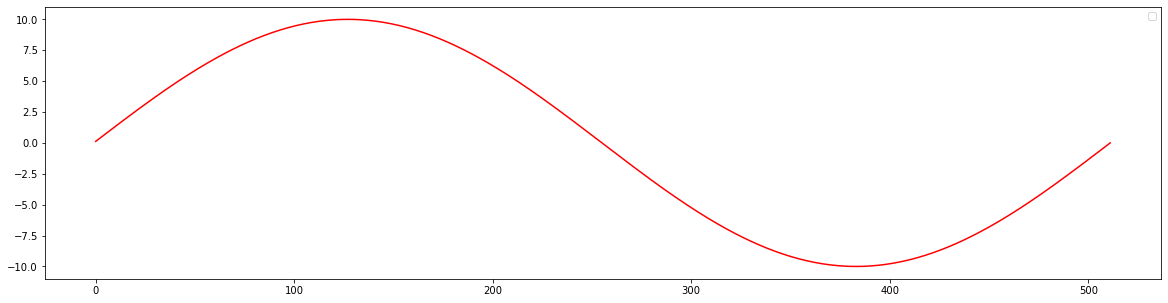

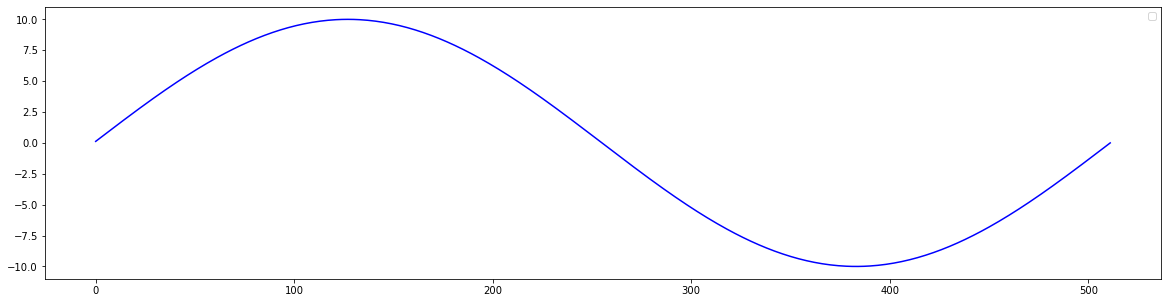

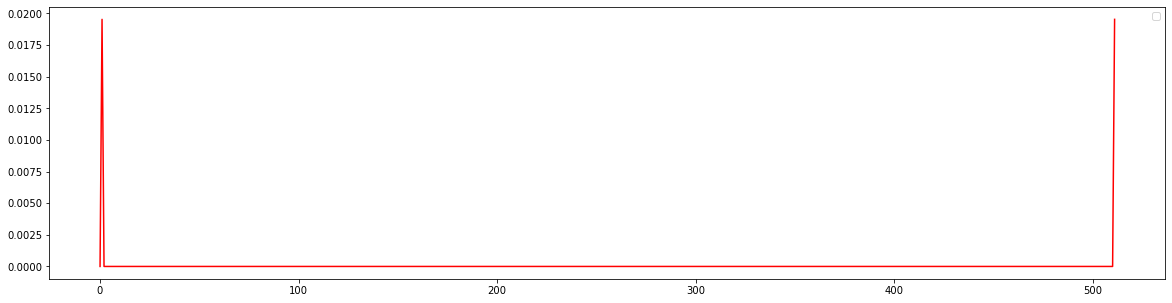

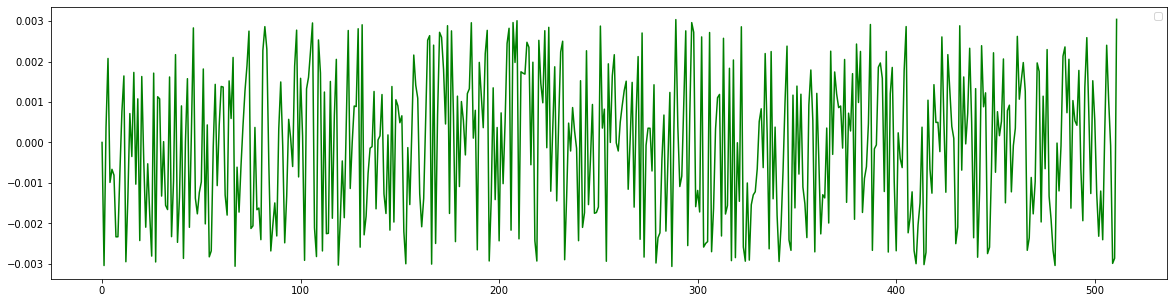

In [3]:
# Константы
N = 512

# Тестовый сигнал
x = sin_range(N)

# Трансформация фурье
x_fft = fft(x, N, 2/N)
A = np.absolute(x_fft) / N
f = np.arctan(x_fft.imag / x_fft.real) / N

# Восстановленный сигнал
x_restored = ifft(x_fft, 2/N)


# Вывод
display_plot([x_restored.real], ['r'], ['Тестовый сигнал'])
display_plot([x], ['b'], ['Тестовый сигнал'])
display_plot([A], ['r'], ['Тестовый сигнал'])
display_plot([f], ['g'], ['Тестовый сигнал'])


<ipython-input-4-14eb5dd57023>:5: RuntimeWarning: divide by zero encountered in true_divide
  p = np.arctan(xp_fft.imag / xp_fft.real)


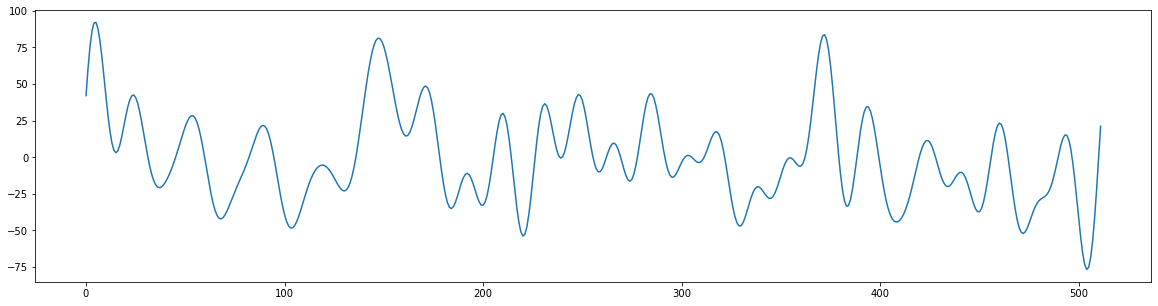

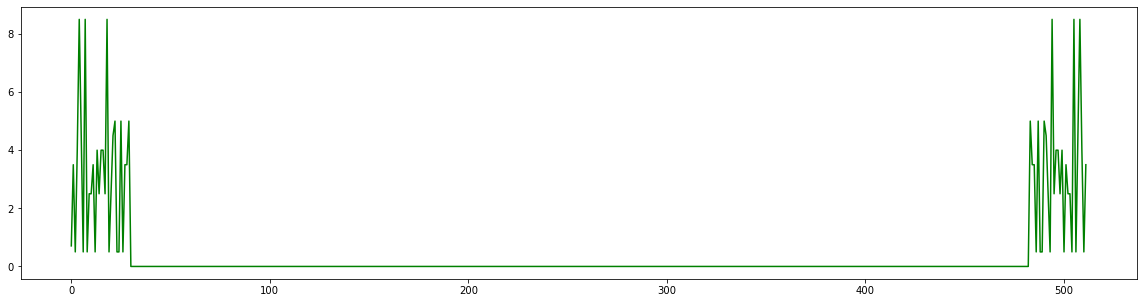

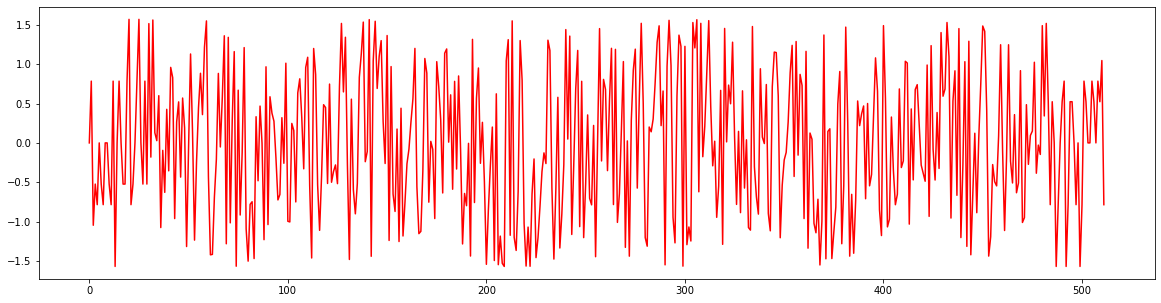

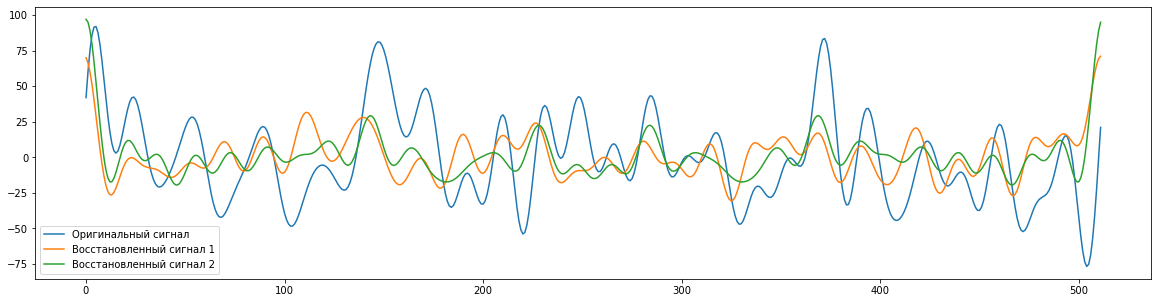

In [4]:
N = 512
xp = polyharmonic(N)
xp_fft = fft(xp, N, 1)
A = np.absolute(xp_fft) / N
p = np.arctan(xp_fft.imag / xp_fft.real)

display_plot([xp])
display_plot([A], ['g'])
display_plot([p], ['r'])

restored_x_1 = np.array([A[0] / 2 + np.sum([A[j] * np.cos(2*np.pi*i*j / N - p[j]) for j in range(int(N/2))]) for i in range(N)])
restored_x_2 = np.array([A[0] / 2 + np.sum([A[j] * np.cos(2*np.pi*i*j / N) for j in range(int(N/2))]) for i in range(N)])
plt.figure(figsize=(20,5))
plt.plot(xp)
plt.plot(restored_x_1)
plt.plot(restored_x_2)
plt.legend(["Оригинальный сигнал", "Восстановленный сигнал 1" , "Восстановленный сигнал 2"])
plt.show()

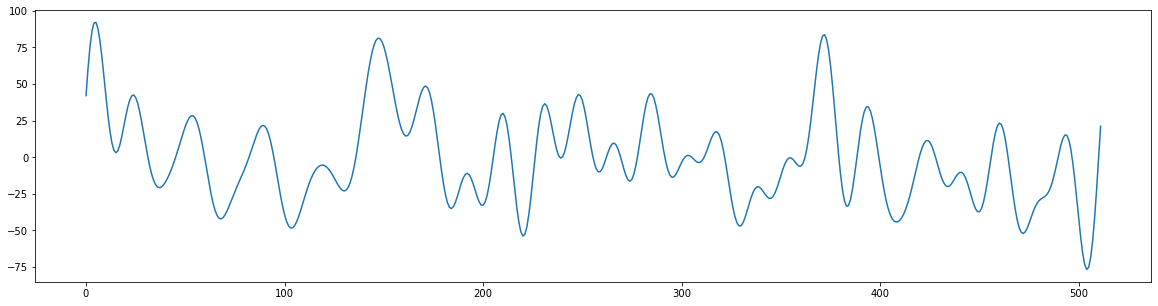

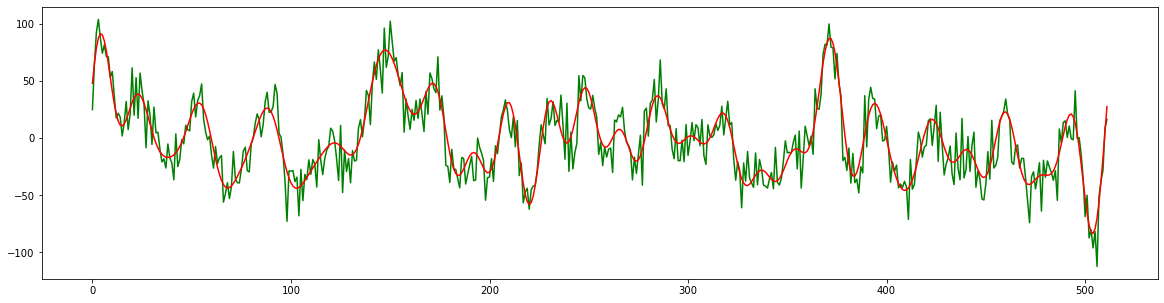

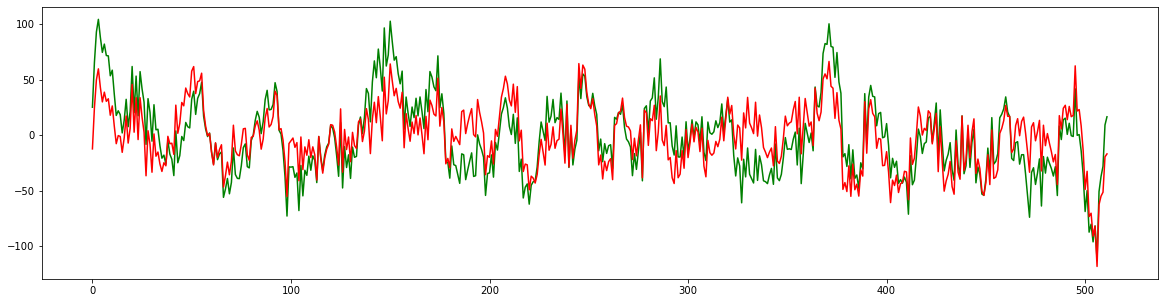

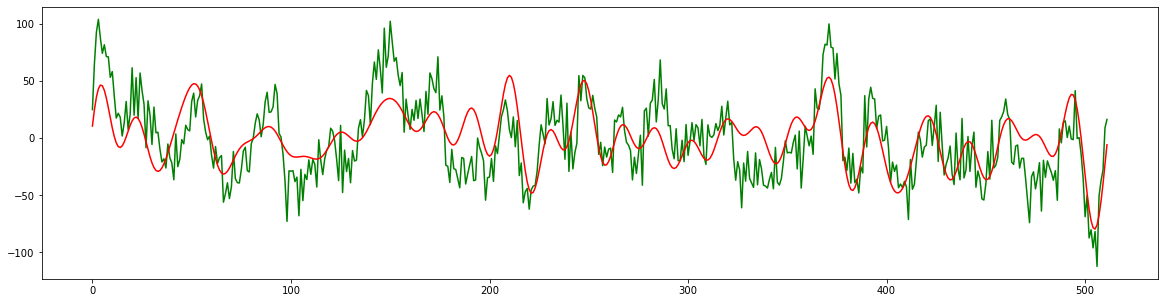

In [52]:
N = int(512)
noise_max = 1
x = xp + np.random.normal(0, 15, size=N)
x_fft = fft(x, N, 1)
A_x = np.abs(x_fft) / N

lowpass_fft = lowpass_filter_fft(x_fft, 2)
lowpass = ifft(lowpass_fft, 1)
high_fft = highpass_filter_fft(x_fft, 8)
high = ifft(high_fft, 1)
band_fft = bandpass_filter_fft(x_fft, 2, 8)
band = ifft(band_fft, 1)

display_plot([xp])
display_plot([x, lowpass], ['g', 'r'])
display_plot([x, high], ['g', 'r'])
display_plot([x, band], ['g', 'r'])